# Tradução Automática de Textos Inglês-Francês com Transformer

Nessa prática, vamos tentar criar um tradutor automático de textos inglês-francês. Para isto, usaremos modelo Transformer de forma a lidar com as informações de texto.   

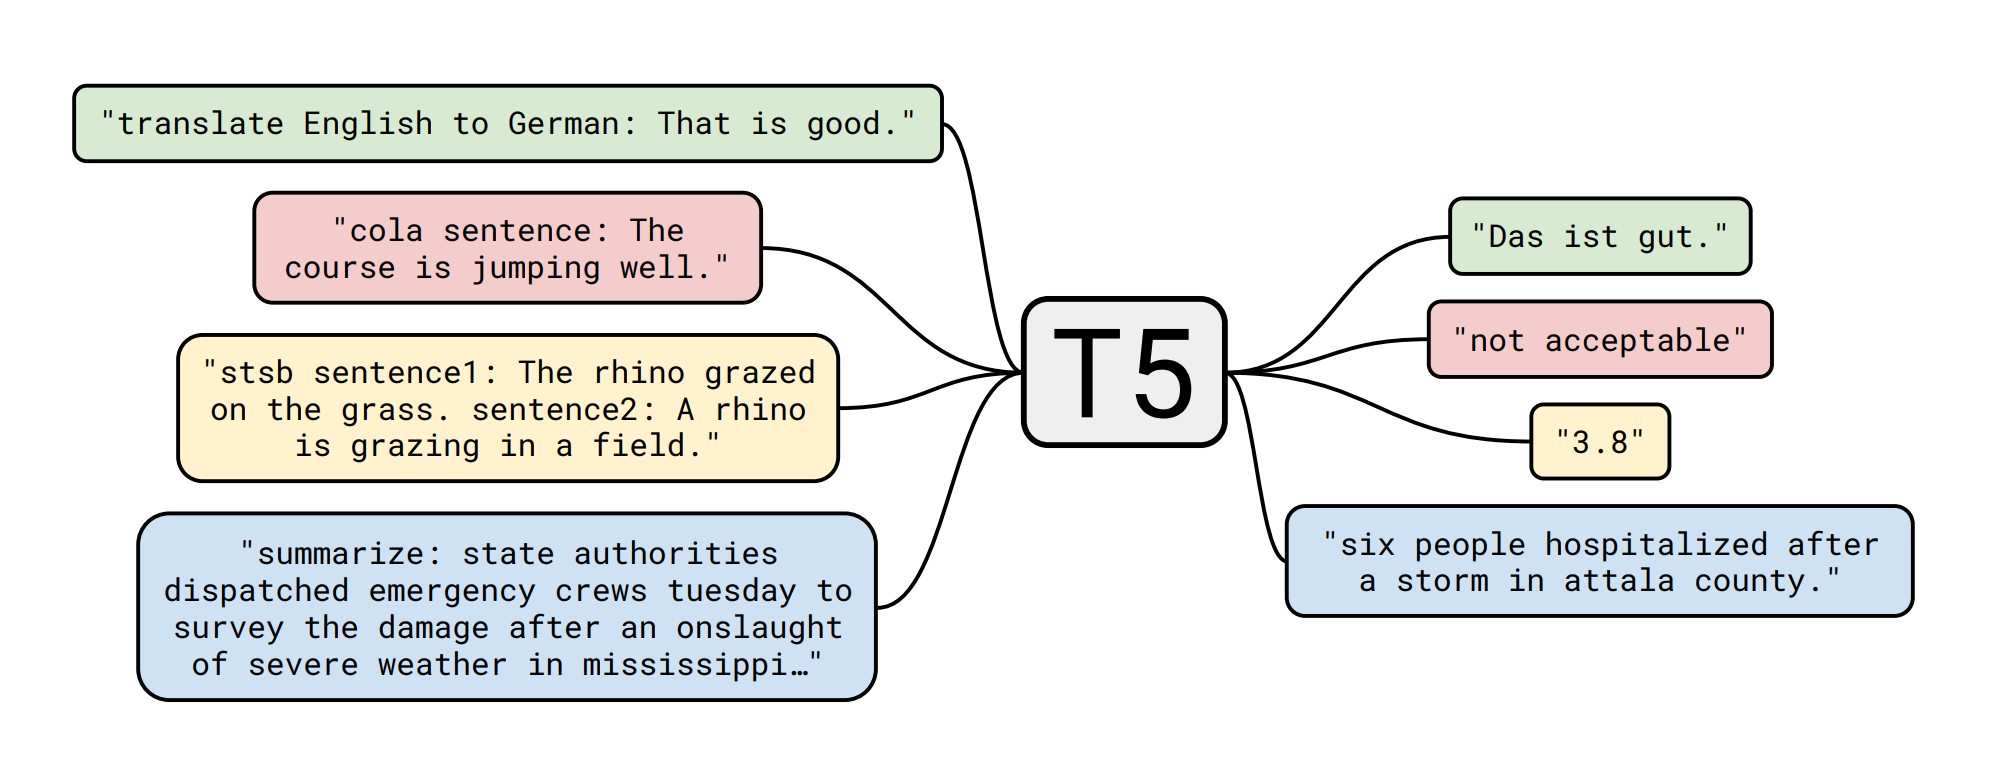

In [ ]:
#hugging face hoje domina a parte de transformers
!pip install --upgrade -q transformers datasets huggingface_hub tensorflow==2.15

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.0 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset

books = load_dataset("opus_books", "en-fr")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/127085 [00:00<?, ? examples/s]

O próprio objeto `dataset` é um objeto [` DatasetDict`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasetdict), que contém uma chave para o conjunto de treinamento, validação e teste (quando houver):

In [ ]:
books #dataset com estrutura de dicionário

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 127085
    })
})

Neste caso, temos apenas um conjunto de treino e, a partir deste, iremos criar um conjunto de treino e validação:

In [ ]:
books = books["train"].train_test_split(test_size=0.2)

In [ ]:
N = 10000
books["train"] = books["train"].select(range(N))

Vamos visualizar a nova estrutura da base de dados

In [ ]:
books

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['id', 'translation'],
        num_rows: 25417
    })
})

Para acessar um elemento real, você precisa primeiro selecionar uma divisão e, em seguida, fornecer um índice:

In [ ]:
books['train'][14]

{'id': '79265',
 'translation': {'en': 'Manners and Customs in 1830',
  'fr': 'Façons d’agir en 1830'}}

Para ter uma ideia de como os dados se parecem, a função a seguir mostrará alguns exemplos escolhidos aleatoriamente no conjunto de dados.

In [ ]:
import datasets
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=5):
    assert num_examples <= len(dataset)
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

In [ ]:
show_random_elements(books["train"])

,id,translation
0,11586,"{'en': 'CHAPTER XXI', 'fr': 'CHAPITRE XXI'}"
1,40783,"{'en': 'You say we are going--""', 'fr': 'Vous dites que nous allons?...'}"
2,55266,"{'en': 'Thanks to Heaven's mercy, he had made the voyage successfully, and had reached home without hindrance.', 'fr': 'Grâce au ciel, il s’était assez bien tiré de la traversée, et était arrivé à Rome sans encombre.'}"
3,67906,"{'en': 'He came in not late for breakfast, and amused all the family by his funand good humour. His mother, quite delighted, said to him:', 'fr': 'Or cette idée ne lui étaitpas venue, puisqu'elle avait bu, avec une simplicité parfaite, à lamémoire bénie de feu Maréchal.'}"
4,119739,"{'en': 'She was suffocating, intoxicated with the darkness, exasperated with the walls which crushed against her flesh, and shuddering also with the dampness, her body perspiring beneath the great drops which fell on her.', 'fr': 'Elle suffoquait, ivre de ténebres, exaspérée de l'écrasement des parois contre sa chair. Et elle frissonnait aussi de l'humidité, le corps en sueur sous les grosses gouttes qui la trempaient.'}"


# Pré-processando os dados

Uma abordagem comum em Processamento de Linguagem Natural (NLP) é usar um dicionário/vocabulário para codificar as palavras presentes em um texto. Há diferentes maneiras de construir o dicionário, mas essencialmente gostaríamos de incluir as palavras mais significativas do nosso conjunto de treino (assumindo que ele vai generalizar bem para o conjunto de teste). Cada palavra em uma passagem de texto será codificada (transformada) em um inteiro associado a uma palavra no nosso dicionário.

Por exemplo, suponha que nosso dicionário é:

{"movie":1, "actor": 2, "actress": 3, "cool":4, "bad":5, "action":6 ... "awesome": 100 ...}

Associamos a palavra movie (a palavra mais comum no nosso conjunto de treinamento) ao número 1, bad ao número 5 e assim por diante. Agora, suponha que tenhamos as seguintes duas frases (já desconsideramos as palavras que não estão no nosso dicionário).

    Frase 1: "movie awesome. Cool actor."

    Frase 2: "movie bad. Awesome actor."

Eles serão codificados como:

    Codificação 1: [1,100,4,2]

    Codificação 2: [1,5,100,2]

É importante lembrar que não precisamos construir este dicionário do zero, visto que vamos utilizar o dicionário aprendido pelo modelo T5. Para fazer tudo isso, instanciamos nosso tokenizer com o método `AutoTokenizer.from_pretrained`, que garantirá:

- obtemos um tokenizer que corresponde à arquitetura do modelo que queremos usar,
- baixamos o vocabulário (dicionário) usado durante o pré-treinamento neste ponto de verificação específico.

Esse vocabulário será armazenado em cache, portanto, não será baixado novamente na próxima vez que executarmos o celular.

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("t5-small")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [ ]:
tokenizer("Hello, this one sentence!")

{'input_ids': [8774, 6, 48, 80, 7142, 55, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

Em vez de uma frase, podemos passar uma lista de frases:

In [ ]:
tokenizer(["Hello, this one sentence!", "This is another sentence."])

{'input_ids': [[8774, 6, 48, 80, 7142, 55, 1], [100, 19, 430, 7142, 5, 1]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1]]}

Para preparar os valores alvos para nosso modelo, precisamos tokenizá-los dentro do gerenciador de contexto `as_target_tokenizer`. Isso garantirá que o tokenizer use os tokens especiais correspondentes aos destinos:

In [ ]:
tokenizer(text_target=["Gudule répondit d’un ton insouciant",
                       "Et qui sait ce que deviendrait le dernier vivant de nous, après une longue solitude sur cette île?."])

{'input_ids': [[2846, 1259, 109, 11781, 155, 3, 26, 22, 202, 12, 29, 16, 7, 32, 6809, 288, 1], [1754, 285, 3, 8870, 197, 238, 20, 2099, 12524, 155, 90, 4635, 21424, 20, 678, 6, 3308, 245, 12280, 31274, 244, 3, 922, 3, 17799, 58, 5, 1]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

Podemos então escrever a função que irá pré-processar nossas amostras. Nós apenas os alimentamos com o `tokenizer` com o argumento` truncation = True`. Isso garantirá que uma entrada mais longa do que o modelo selecionado será **truncada** para o comprimento máximo aceito pelo modelo. O **preenchimento** será tratado mais tarde (em um Data Collator), portanto, preenchemos os exemplos de entrada até o tamanho indicado (parâmetro `max_length`=128 tokens) para termos um padrão na entrada do modelo. Entradas que geraram mais de 128 tokens serão truncadas em 128.

O modelo T5 requer um **prefixo** especial para colocar antes das entradas, sendo assim, devemos adaptar a célula a seguir.

Ele está descartando o 11, 12, 13 na segunda linha e preenchendo a primeira linha com zeros

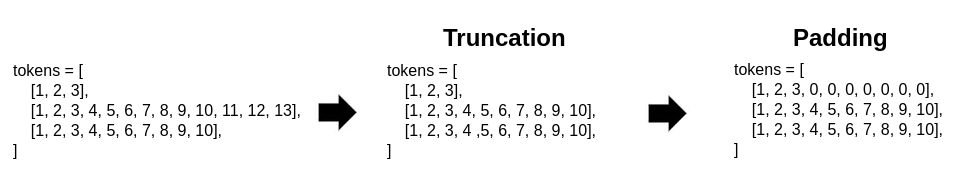

In [ ]:
source_lang = "en"
target_lang = "fr"
prefix = "translate English to French: "


def preprocess_function(examples):
    # adiciona o prefixo para uma das entradas
    inputs = [prefix + example[source_lang] for example in examples["translation"]]
    # monta a lista dos textos targets
    targets = [example[target_lang] for example in examples["translation"]]

    # tokeniza os textos de entrada
    model_inputs = tokenizer(inputs, max_length=128, truncation=True)
    # tokeniza os textos de saida
    labels = tokenizer(text_target=targets, max_length=128, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

Esta função funciona com um ou vários exemplos. No caso de vários exemplos, o tokenizer retornará uma lista de listas para cada chave:

In [ ]:
preprocess_function(books['train'][:2])

{'input_ids': [[13959, 1566, 12, 2379, 10, 71, 10875, 3, 32, 26, 1211, 3, 9, 8115, 16, 17912, 13, 8, 25425, 2677, 28, 84, 34, 47, 2303, 5, 1], [13959, 1566, 12, 2379, 10, 96, 3774, 33, 59, 3, 9, 14620, 44, 8, 6358, 6, 13, 503, 5, 1]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'labels': [[2435, 3, 28851, 16, 4075, 15, 3, 7, 31, 35, 1215, 3828, 9, 6, 3, 51, 17587, 110, 11559, 7, 9148, 10873, 2483, 3, 693, 4104, 142, 51, 721, 5, 1], [1636, 3, 1930, 3, 29, 31, 6738, 824, 1194, 330, 245, 93, 14620, 15, 7, 146, 24334, 10, 327, 3, 6738, 233, 3704, 1]]}

Para aplicar esta função em todos os pares de sentenças em nosso conjunto de dados, apenas usamos o método `map` do nosso objeto` conjunto de dados` que criamos anteriormente. Isso aplicará a função em todos os elementos de todas as divisões no `dataset`, então nossos dados de treinamento, validação e teste serão pré-processados em um único comando.

In [ ]:
tokenized_books = books.map(preprocess_function, batched=True)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25417 [00:00<?, ? examples/s]

Os resultados são armazenados em cache automaticamente pela biblioteca Datasets para gasto excessitvo de tempo nesta etapa na próxima vez em que executarmos o notebook. A biblioteca Datasets normalmente é inteligente o suficiente para detectar quando a função passada ao `map` mudou (e, portanto, requer não usar os dados de cache). Por exemplo, ele detectará corretamente se você alterar a tarefa na primeira célula e executar o notebook novamente. Datasets avisa quando usa arquivos em cache, você pode passar `load_from_cache_file = False` na chamada para `map` para não usar os arquivos em cache e forçar o pré-processamento a ser aplicado novamente.

Observe que passamos `batched = True` para codificar os textos por lotes juntos. Isso é para aproveitar todos os benefícios do tokenizer rápido que carregamos anteriormente, que usará multithreading para tratar os textos em um lote simultaneamente.

# Fine-tuning do Modelo

Agora que nossos dados estão prontos, podemos baixar o modelo pré-treinado e ajustá-lo. Como nossa tarefa é do tipo sequência a sequência, usamos a classe `AutoModelForSeq2SeqLM`. Como com o tokenizer, o método `from_pretrained` irá baixar e armazenar em cache o modelo para nós.

In [ ]:
from transformers import TFAutoModelForSeq2SeqLM, DataCollatorForSeq2Seq

model = TFAutoModelForSeq2SeqLM.from_pretrained("t5-small")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


Para a etapa de ajuste do modelo, em TensorFlow, comece convertende os seus conjuntos de dados para o formato `tf.data.Dataset` com to_tf_dataset. Especifique as entradas e os rótólos em colunas, se deve embabaralhar a ordem do conjunto de dados, o tamanho do batch, e alguma função de processamento dos dados (collate):

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model, return_tensors="tf")

tf_train_set = tokenized_books["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "labels"],
    shuffle=True,
    batch_size=64,
    collate_fn=data_collator,
)

tf_val_set = tokenized_books["test"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "labels"],
    shuffle=False,
    batch_size=64,
    collate_fn=data_collator,
)

Por fim, precisamos definir qual o otimizador será utilizado, assim como os seus respectivos hyperparâmetros.

In [ ]:
from transformers import create_optimizer, AdamWeightDecay

optimizer = AdamWeightDecay(learning_rate=2e-5, weight_decay_rate=0.01)

Tudo pronto! Agora só precisamor compilar o modelo para verificar se está tudo correto e, posteriormente, executarmos o treinamento.

In [ ]:
model.compile(optimizer=optimizer)

In [ ]:
model.fit(x=tf_train_set, validation_data=tf_val_set, epochs=3)

Epoch 1/3


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
157/157 [==============================] - 415s 2s/step - loss: 2.1234 - val_loss: 1.8364
Epoch 2/3
157/157 [==============================] - 367s 2s/step - loss: 2.0435 - val_loss: 1.7895
Epoch 3/3
157/157 [==============================] - 369s 2s/step - loss: 1.9991 - val_loss: 1.7577


Uma vez que o modelo está treinado, é interessante investigar como estão as predições do mesmo. Como utilizamos a Huggingface, uma das formas mais diretas de investigar as predições do modelo é através da criação de um `pipeline`, cujos parâmetros indicam qual tarefa será realizada (translation_en_fr), um modelo e um tokenizador.

In [ ]:
from transformers import pipeline

en_fr_translator = pipeline(f"translation_{source_lang}_to_{target_lang}",
                            model=model,
                            tokenizer=tokenizer)

In [ ]:
en_fr_translator("How old are you?")

[{'translation_text': ' quel âge êtes-vous?'}]

Agora, iremos verificar as predições do modelo treinado com 5 amostras aleatórios que estão no conjunto de validação.

In [ ]:
import numpy as np

for val_sample in np.random.choice(books['test'], size=5):
  original = val_sample['translation'][source_lang]
  target_text = val_sample['translation'][target_lang]
  translation = en_fr_translator(original)
  print(f"Original Text: {original} \n Prediction: {translation[0]['translation_text']} \n Answer: {target_text}")
  print(30*"--")

Original Text: I was unwilling to get into a pointless argument with the Canadian and didn't reply. 
 Prediction: Je n'étais pas disposé à entrer dans un argument inutile avec le Canadien et je ne répondais pas. 
 Answer: Je ne voulus pas entamer avec le Canadien une discussion sans utilité, et je ne répondis pas.
------------------------------------------------------------
Original Text: My question was unanswered. 
 Prediction: Ma question n'a pas été réglée. 
 Answer: Ma demande n'obtint aucune réponse.
------------------------------------------------------------
Original Text: You are right," cried the affrighted Mme. Bonacieux; "let us fly! Let us save ourselves." 
 Prediction: Vous avez raison, cria Mme Bonacieux, affaiblie, et nous sauvons. 
 Answer: -- Oui, oui, vous avez raison, s'écria Mme Bonacieux effrayée; fuyons, sauvons-nous.»
------------------------------------------------------------
Original Text: Harding and his companions had left Granite House at twelve minutes pa